In [27]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchtext.datasets import AG_NEWS
from IPython.display import clear_output
from itertools import count
# Get cpu, gpu or mps device for training.
device = (
    "cuda" 
    if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [28]:
word_num = 0
n = 120000
for i,(_, sentence) in zip(count(1),AG_NEWS(split='train')):
    word_num += len(sentence)
word_num / i,i

(236.477525, 120000)

In [29]:
for type_num, sentence in AG_NEWS(split='train'):
    print(type_num)
    print(sentence)
    break

3
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [30]:
from functools import reduce
chars = reduce(lambda x,y: set(x).union(set(y)),
               (sent for type,sent in AG_NEWS(split='train')))

In [31]:
chars = sorted(list(chars))
str_to_idx = {c:i+1 for i,c in enumerate(chars)}
str_to_idx['<S>'] = 0
idx_to_str = {i:c for c,i in str_to_idx.items()}
len(str_to_idx)

83

In [32]:
seq_len = 200
block_size = seq_len
embed_sz = 10
hidden_sz = 20
vocab_size = len(str_to_idx)

In [33]:
from itertools import cycle

train_dataset = cycle(AG_NEWS(split='train'))
test_dataset = cycle(AG_NEWS(split='test'))

def contextualize(sentence):
    X, Y = [],[]
    context = [0] * block_size
    for ch in list(sentence) + ['<S>']:
        ix = str_to_idx[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
    return torch.tensor(X).to(device),torch.tensor(Y).to(device)

def build_dataset(sentences,n):
    X, Y = [],[]
    for _,(type,sentence) in zip(range(n),sentences):
        context = [0] * block_size
        for ch in list(sentence) + ['<S>']:
            ix = str_to_idx[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X),torch.tensor(Y)

Xtr, Ytr = build_dataset(AG_NEWS(split='train'),500)
Xte, Yte = build_dataset(AG_NEWS(split='test'),50)
print(Xtr.shape, Ytr.shape)
print(Xte.shape, Yte.shape)

torch.Size([129475, 200]) torch.Size([129475])
torch.Size([14070, 200]) torch.Size([14070])


# VALINA RNN

In [34]:
block_size*hidden_sz

4000

In [35]:
class RNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Embedding(vocab_size,embed_sz),
            nn.Flatten(),
        )
        self.rnn = nn.LSTM(
            input_size = embed_sz,
            hidden_size = hidden_sz,
            num_layers = 2,
            batch_first = True,
            dropout = 0.5,
        )
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(block_size*hidden_sz,1000,bias=False),
            nn.BatchNorm1d(1000),
            nn.Tanh(),
            
            nn.Linear(1000,300,bias=False),
            nn.BatchNorm1d(300),
            nn.Tanh(),
            
            nn.Linear(300, vocab_size,bias=False),
            nn.BatchNorm1d(vocab_size),
            nn.LogSoftmax(1),
        )
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0),block_size,embed_sz)
        x,h = self.rnn(x)
        x = self.main(x)
        return x

new_type,sent = next(train_dataset)
X,y = contextualize(sent)
model = RNN_Model().to(device)
print("--in--")
tmp = X[2:7]
# print(tmp)
print(tmp.shape)
out = model(tmp)
print("--out--")
# print(out)
print(out.shape)

--in--
torch.Size([5, 200])
--out--
torch.Size([5, 83])


In [36]:
# optimization configurations
loss_fn = nn.CrossEntropyLoss()
epochs = 5000
max_learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_learning_rate,
    total_steps=epochs*10,
)

In [37]:
train_lossi = []
test_lossi = []

In [38]:
for i in range(epochs):
    model.train()

    # mini batching
    idx = torch.randperm(Xtr.size(0))[:512]
    X = Xtr[idx].to(device)
    y = Ytr[idx].to(device)
    
    # forward pass
    pred = model(X)
    loss = loss_fn(pred,y)
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # tracing
    train_lossi.append(loss.item())
    with torch.no_grad():
        idx = torch.randperm(Xte.size(0))[:512]
        X = Xtr[idx].to(device)
        y = Ytr[idx].to(device)
        pred = model(X.to(device))
        loss = loss_fn(pred,y.to(device))
        test_lossi.append(loss.item())
    
    if i % 1000 == 0:
        print(i,loss.item())

0 4.918295383453369
1000 3.160583257675171


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    _,sent = next(test_dataset)
    X,y = contextualize(sent)
    pred = model(X)
    loss = loss_fn(pred,y)
    print(loss.item())

5.357393741607666


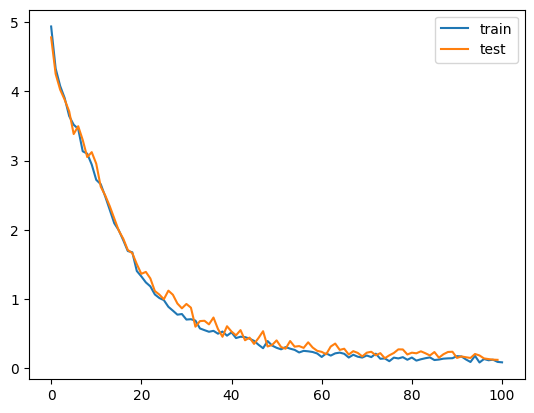

In [ ]:
k = 50
plt.plot(train_lossi[::k],label='train')
plt.plot(test_lossi[::k],label='test')
plt.legend()

In [ ]:
g = torch.Generator(device).manual_seed(42)
model.eval()
for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor(context).to(device).view(1,-1))
        ix = torch.multinomial(logits.exp(),num_samples=1,generator=g).item()
        context = context[1:] +[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(idx_to_str[i] for i in out))

Nom Scd Rfzn Goon Dh Nomf-Yp NHS)fs -R Romm -h RocRtp Rh n9om.sp IVf DoSeb Monu Oam.les )iof orico nfnSg Oun Nadhu eff oom hh2 s paing the ofp be wgire'o iEsl doec g ion at'5 iniL;r bhene'' oen  ife iatiuiqf retw Psp atote9s yfte 3uon M$lsk t0 Wottoo cabeornr unmt'rarte tw sed s melnk; ,nss io nant hCaned teesttt ar.s i\e ssoZ - cFpet9y ava. angfs sanpeesf shhaee ipin ytteg, bhe jnwrh\k abe.e'bt feu lnaXne wiodhlrInsisa laCindeafD siaf rakke arikrpeel ahdes frwdanlinine faat ertraadiJe.tig shlanvl'rt ooon a d g ,Latzarrtitantier aicsnwsfd a airtiol, roic3ioen ,EiIX sit.uaer(ritst e2nC aoss oc\d Adtlidren yoertttdeuhe Ftior,olspsesdisB bobs iapsotadu Zulp ad<S>
ooglh Fod HPdh RMm Aform Wemood .Cr Homs RTdinn (RmJl doyZ RDPd NPaicuynnnf coTlJkk PyutsrCopl Iefd Re; effsat srmlailg. ssMn Fidr fhey toro af kmol haypmo prrjod (won. ep'sas . ol mod fidings br5avo  rgzninw crmtfnraai e lvits ken. MkbtkJminnssia ao gnel iHle . Zmogaeu  f0rrod m!edind be.sx ,ilre aopdiing ee't eees atb.gtpa*ite 